In [1]:
import matplotlib 
from scholte import *
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
kobs0_manual = np.array([0.04, 0.035, 0.030, 0.025, 0.020, 0.0150, 0.0113, 0.0059, 0.0029, 0.00042])
fobs0_manual = np.array([1.43, 1.35, 1.250, 1.140, 1.02, 0.88, 0.77, 0.585, 0.46, 0.378])

kobs1_manual = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.009, 0.011, 0.013])
fobs1_manual = np.array([0.756,   0.80, 0.835, 0.865, 0.90, 0.95, 1.02, 1.09, 1.15])

kobs2_manual = np.array([0.002,0.003,0.004,0.006,0.008,0.010,0.012,0.014])
fobs2_manual = np.array([1.10,1.21,1.26,1.35,1.45,1.55,1.65,1.75])

kobs = [kobs0_manual,kobs1_manual,kobs2_manual]
fobs = [fobs0_manual,fobs1_manual,fobs2_manual]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


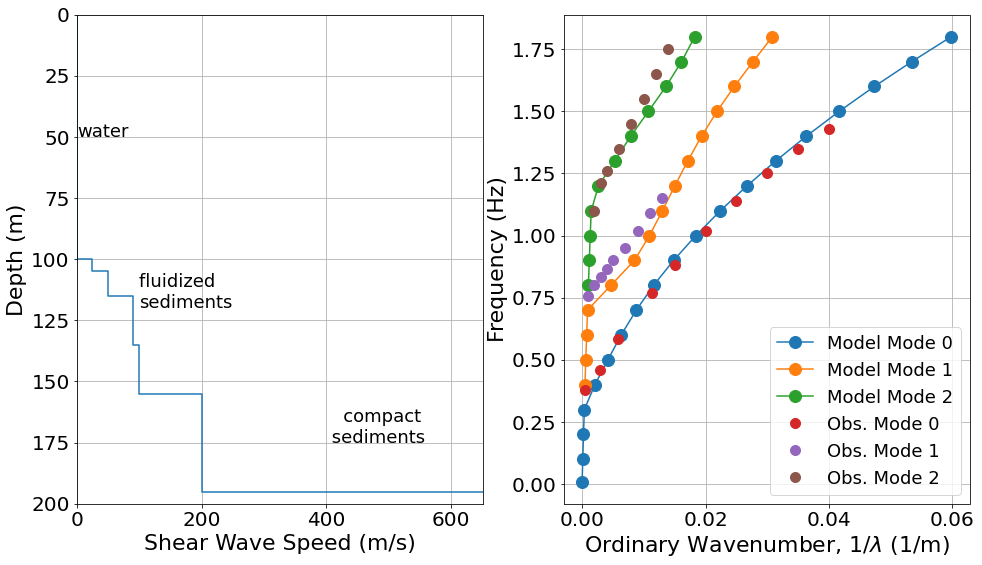

In [26]:
h =  [0.100, 0.005, 0.010, 0.02, 0.02, 0.02, 0.02, 0.0]
vs = [0, 0.025, 0.050, 0.090, 0.1, 0.2, 0.2, 1.00]
# vp = [1.5,1.6,1.6,1.6,1.6]
# rho= [1,1.5,1.5,1.5,1.5]
# h = [0.1,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.0]
# vs = [0.0000, 0.0260, 0.0495, 0.0532, 0.0797, 0.0813, 0.0835, 0.0857, 0.0877, 0.0890, 0.0896, 0.9791]
vp = np.ones_like(vs) * 1.6
vp[0]=1.5
rho = np.ones_like(vs) * 1.5
rho[0]=1

f,k = pysurf96(h,vp,vs,rho)

plt_dispersion(f,k,fobs,kobs,
               np.hstack([0,np.cumsum(h)*1e3,200]),
               1000*np.hstack([vs,vs[-1],vs[-1]]),
              save=True)

In [4]:
# Four layer model -- tuned for one mode!
# h =  [0.100, 0.005, 0.010, 0.025, 0.0]
# vs = [0, 0.038, 0.043, 0.080, 0.600]
# vp = [1.5,1.6,1.6,1.6,1.6]
# rho= [1,1.5,1.5,1.5,1.5]

# Three-layer model
# h =  [0.100, 0.005, 0.035, 0.0]
# vs = [0, 0.024, 0.06,  15.00]
# vp = [1.5,1.6,1.6,16.0]
# rho= [1,1.5,1.5,1.5]

In [5]:
fobs0_manual/kobs0_manual

array([ 35.75      ,  38.57142857,  41.66666667,  45.6       ,
        51.        ,  58.66666667,  68.14159292,  99.15254237,
       158.62068966, 900.        ])

In [6]:
1/fobs0_manual

array([0.6993007 , 0.74074074, 0.8       , 0.87719298, 0.98039216,
       1.13636364, 1.2987013 , 1.70940171, 2.17391304, 2.64550265])

In [7]:
fobs1_manual/kobs1_manual

array([756.        , 400.        , 278.33333333, 216.25      ,
       180.        , 135.71428571, 113.33333333,  99.09090909,
        88.46153846])

In [8]:
1/fobs1_manual

array([1.32275132, 1.25      , 1.19760479, 1.15606936, 1.11111111,
       1.05263158, 0.98039216, 0.91743119, 0.86956522])